# Project 3

Joseph Tiu
October 27, 2021

In this lab, we will be looking at the panel method of approximating surfaces using sources and sinks. We will mainly be using derivations that were made in class and converting them to a cartesian coordinate system and implementing these equations into Python.

## Problem 1: Flow Over a Non-Rotating Cylinder
### 1a. Building the Panel Method Solver
In this section, we will mainly be looking at how the panel method solver can be made in Python. We will be basing a good portion of the methods from Lorena Barba's AeroPython Lesson, but we will also be making modifications to her program.

We can start building our panel method program by importing the necessary packages. The math and numpy packages are used for their built-in math functions and constants while the pyplot package is used for it's plotting functions. We will also be using anew package this time called scipy for it's integration package. This is different from the usual numpy.trapz() since scipy.integrate can integrate functions given a set of endpoints whereas numpt.trapz() simply finds the area under a set of data. This allows us to simply create a function of our integrand instead of creating a set of points defined by our integrand.

In [79]:
import math
import numpy as np

import matplotlib.pyplot as plt

from scipy import integrate

In order to organize our data, we can create and store each panel as an object called Panel. This will initially store the endpoints, ($x_a, y_a$) and ($x_b, y_b$), and will be used to store the properties of each panel. Since the midpoint, ($x_c, y_c$), and the normal angle of the panel, $\vec{n}$ depend only on the geometry of the panel, we can derive them as shown below:

$$(x_c, y_c) = (\frac{x_a + x_b}{2}, \frac{y_a + y_b}{2})$$

We have three scenarios for the normal vector of each panel, for panels defined in a counter-clockwise style. For $\Delta y = y_b - y_a$ and $\Delta x = x_b - x_a$, we have the following:

$$\vec{n} = \frac{\langle\Delta y, -\Delta x\rangle}{|\langle\Delta y, -\Delta x)\rangle}, \text{ for } \Delta x \neq 0$$
$$\vec{n} = \langle-1, 0\rangle,\text{ for } \Delta x = 0, \Delta y < 0$$
$$\vec{n} = \langle 1, 0\rangle,\text{ for } \Delta x = 0, \Delta y > 0$$

This is based on the fact that the slope of the normal vector multiplied by the slope of a line should equal to negative one, and that the normal vector is to be outwards positive from the panel. Using $\vec{n}$, we can determine the normal-freestream angle, $\beta$, by using the dot product between $\vec{n}$ and an input freestream velocity vector $\vec{V_\infty}$:

$$\cos\beta = \hat{n} \cdot  \hat{V}_\infty$$
$$\beta = \cos^{-1}{(\hat{n} \cdot  \hat{V}_\infty)}$$

Finally, we can determine the angle of the normal vector in radians which will be relevant in later calculations:

$$\theta_n = 2\pi + \tan^{-1}\left(\frac{-\Delta x}{\Delta y}\right), \text{ for } \Delta x > 0$$
$$\theta_n = \tan^{-1}\left(\frac{-\Delta x}{\Delta y}\right), \text{ for } \Delta x < 0$$
$$\theta_n = \pi, \text{ for } \Delta x = 0, \Delta y < 0$$
$$\theta_n = 0, \text{ for } \Delta x = 0, \Delta y > 0$$

The normal angle can be used to determine the panel's orientation (for a typical airfoil or cylinder), where normal angles less then $\pi$ can be assumed to be on the upper surface while the opposite is true for th elower surface. For the inverse tangent, we will be using the atan2() function from the math package which takes two input arguments, can handle $\Delta y = 0$ and returns and angle from $-\pi$ to $\pi$. We also want to initialize properties of panel strength, tangential velocity and pressure coefficients for future calculations and data storage. Shown below are the equations implemented to Python:

In [80]:
class Panel:
    def __init__(self, xa, ya, xb, yb, V_inf = [1,0]):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb

        self.xc, self.yc = ((xa + xb)/2, (ya + yb)/2)
        self.length = np.sqrt((xa - xb)**2 + (ya - yb)**2)

        if xb - xa != 0.:
            norm = [yb - ya, xa - xb]
            if xb - xa > 0.:
                self.normAngle = 2*math.pi + math.atan2((xa - xb),(yb - ya))
            elif xb - xa < 0.:
                self.normAngle = math.atan2((xa - xb),(yb - ya))
        else:
            if ya - yb > 0.:
                self.normAngle = math.pi
                norm = [-1, 0]
            else:
                self.normAngle = 0
                norm = [1, 0]

        V_inf_unit = V_inf / np.linalg.norm(V_inf)
        norm_unit = norm / np.linalg.norm(norm)
        V_inf_dot_norm = np.dot(V_inf_unit, norm_unit)

        self.beta = np.arccos(V_inf_dot_norm)

        if self.normAngle <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

        self.strength = 0
        self.vt = 0
        self.cp = 0

Now, in order to solve for the panel strengths, we need to solve for the strength-normalized contributions of each panel ($j$) on a single panel ($i$). This comes from the integral term of the normal velocity equation for a point at the center of a panel as shown below:

$$V_{n} = V_\infty \cos\beta_i + \frac{\lambda_i}{2} + \sum_{j=1}^n\frac{\lambda_j}{2\pi}\int_j\frac{\partial}{\partial\vec{n}_i}(\ln r_{i,j})ds_j = 0$$

We can first convert the coordinate system to cartesian by noting that $r = \sqrt{(x_{c,i} - x_j(s_j))^2 + (y_{c,i} - y_j(s_j))^2}$ which gives us the following:

$$V_\infty \cos\beta_i + \frac{\lambda_i}{2} + \sum_{j=1}^n\frac{\lambda_j}{2\pi}\int_j\frac{\partial}{\partial\vec{n}_i}\left(\ln \sqrt{(x_{c,i} - x_j(s_j))^2 + (y_{c,i} - y_j(s_j))^2}\right)ds_j = 0$$

$$V_\infty \cos\beta_i + \frac{\lambda_i}{2} + \sum_{j=1}^n\frac{\lambda_j}{4\pi}\int_j\frac{\partial}{\partial\vec{n}_i}\left(\ln (x_{c,i} - x_j(s_j))^2 + (y_{c,i} - y_j(s_j))^2\right)ds_j = 0$$

We can solve this by taking an implicit derivative of both $x$ and $y$ with respect to $\vec{n}$:

$$V_\infty \cos\beta_i + \frac{\lambda_i}{2} + \sum_{j=1}^n\frac{\lambda_j}{4\pi}\int_j\left( \frac{2(x_{c,i} - x_j(s_j))\frac{\partial x_{c,i}}{\partial \vec{n}} + 2(y_{c,i} - y_j(s_j))\frac{\partial y_{c,i}}{\partial \vec{n}}}{(x_{c,i} - x_j(s_j))^2 + (y_{c,i} - y_j(s_j))^2}\right)ds_j = 0$$

$$V_\infty \cos\beta_i + \frac{\lambda_i}{2} + \sum_{j=1}^n\frac{\lambda_j}{2\pi}\int_j\left( \frac{(x_{c,i} - x_j(s_j))\frac{\partial x_{c,i}}{\partial \vec{n}} + (y_{c,i} - y_j(s_j))\frac{\partial y_{c,i}}{\partial \vec{n}}}{(x_{c,i} - x_j(s_j))^2 + (y_{c,i} - y_j(s_j))^2}\right)ds_j = 0$$

The integral term only consists of geometric variables such that we can solve the integral without any knowledge of the stream or strength conditions. The $x_{c,i}$ and $y_{c,i}$ terms are constants that refer to the control point (located at the center) of a given panel $i$ while the $x_j$ and $y_j$ terms refers to a point on another sheet $j$ that will affect the control point of $i$. 

We still do not have the implicit terms $\frac{\partial x_{c,i}}{\partial \vec{n}}$ and $\frac{\partial y_{c,i}}{\partial \vec{n}}$. These terms refer to the variation of the control point location with respect to the unit normal vector. We can expect the relationship between $x_{c,i}$, $y_{c,i}$ and $\vec{n}$ to be based on the angle made by the normal vector with the $x$-axis, since the unit normal vector has a magnitude of one and a direction given by the panel geometry:

$$\frac{\partial x_{c,i}}{\partial \vec{n}} = \cos\theta_{n_i}$$
$$\frac{\partial y_{c,i}}{\partial \vec{n}} = \sin\theta_{n_i}$$

As for the $x_j$ and $y_j$ values as a function of path length $s_j$, we can express the $xy$-coordinates using the start point $x_a$ and $y_a$ as well as the angle of the panel. The angle of the panel and the angle of the normal are related by an offset of $\frac{\pi}{2}$, letting us use the angle of the normal vector rather than defining a new angle:

$$x_j(s_j) = x_{a,j} + s_j\cos(\theta_{panel}) = x_{a,j} + s_j\cos(\theta_{n, j} + \frac{\pi}{2}) = x_{a,j} - s_j\sin(\theta_{n, j})$$
$$y_j(s_j) = y_{a,j} + s_j\sin(\theta_{panel}) = x_{a,j} + s_j\sin(\theta_{n, j} + \frac{\pi}{2}) = x_{a,j} + s_j\cos(\theta_{n, j})$$

We now have all the terms we need in terms of something we know. In order to conduct this integral, we can use the scipy function integrate.quad(). The input of this function has to be a function so we can define a function called integrand which will be the input of our integration function. We also need bounds of integration, which can be taken from the above equations where the bounds go from $s_j = 0$ to $s_j = s_j$ where $s_j$ is the total panel length of panel $j$.

Below is the function that applies the discussed integration:

In [81]:
def integral_normal(p_i, p_j):
    
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.normAngle) * s)) * math.cos(p_i.normAngle) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.normAngle) * s)) * math.sin(p_i.normAngle)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.normAngle) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.normAngle) * s))**2))
                 
    return integrate.quad(integrand, 0.0, p_j.length)[0]

After solving for the panel strengths, we can use the velocity potential function to get the velocity at each control point by deriving the potential function with respect to the unit tangent vector of each panel. The tangential velocity function is much like the normal velocity function but it involves the tangential components of each value rather than the normal component. The choice of the tangent vector is arbitrary (can be from one end to another end) since the governing equations that we will be using to solve for pressure only depends on the magnitude of the velocity and not the specific direction or sign. Because of this, we can arbitrarily choose that the tangent vector points in the same counter-clockwise direction that we are using to define our panels. This gives us the following expression for the angle of our defined tangential vector:

$$\theta_{t,i} = \theta_{n,i} + \frac{\pi}{2}$$

We can start by looking for the tangential component of the freestream velocity using the angle between the normal component and the freestream, $\beta$.  as shown below:

$$V_{t, \infty} = V_\infty\cos\theta_t = V_\infty\cos(\theta_n + \frac{\pi}{2}) = -V_\infty\sin\theta_n$$

This was rather simple and closely resembles the normal component function but uses a negative $\sin()$ rather than a $\cos()$. The only other main difference is in the $\frac{\partial x_{c,i}}{\partial \vec{t}}$ and $\frac{\partial y_{c,i}}{\partial \vec{t}}$ terms as opposed to the $\frac{\partial x_{c,i}}{\partial \vec{n}}$ and $\frac{\partial y_{c,i}}{\partial \vec{n}}$ terms. In order to get the $x$ and $y$ variation with respect to the tangent vector, we can simply convert the equations to use $\theta_t$ in a similar fashion:

$$\frac{\partial x_{c,i}}{\partial \vec{t}} = \cos\theta_{t,i} = \cos(\theta_{n,i} + \frac{\pi}{2}) = -\sin\theta_{n,i}$$
$$\frac{\partial y_{c,i}}{\partial \vec{t}} = \sin\theta_{t,i} = \sin(\theta_{n,i} + \frac{\pi}{2}) = \cos\theta_{n,i}$$

This allows us to simply reuse the $\theta_{n,i}$ variable for our other calculations. Summing up the new terms will give us the tangential velocity at each point moving counter-clockwise on the surface (almost like a circulation). Again, the actual sign of the velocity doesn't matter since we are squaring the velocities in Bernoulli's equation.

In [82]:
def integral_tangential(p_i, p_j):
    
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.normAngle) * s)) * math.sin(p_i.normAngle) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.normAngle) * s)) * math.cos(p_i.normAngle)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.normAngle) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.normAngle) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

Now, we want to create a function that takes in a set of $x$ and $y$ points that defines a body going in the counter-clockwise direction as well as a two-dimensional freestream velocity vector. 

We can first start by initializing an array of panels and initializing each panel based on the given endpoints and freestream velocity vector. Next, we can calculate each panel's contribution to each other and form a square matrix which will be used to solve for the sheet strengths. We also need to solve a column vector using the freestream velocity and the angle of the normal with respect to the freestream.

Once all these matrices and objects are set, we can use the numpy matrix solver linalg.solve() to solve for the sheet strengths and set the solved sheet strengths to each panel appropriately.

In [83]:
def panelMethod(V_inf, x_ends, y_ends):
    #Define number of panels as number of ends - 1
    N_panels = len(x_ends) - 1
    #Creates an empty array of objects
    panels = np.empty(N_panels, dtype=object)

    #For every endpoint pair, create one panel in the array
    for i in range(N_panels):
        #Input of endpoints and freestream velocity
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1], V_inf)

    #Create A vector to solve the system of linear equations for strengths
    A = np.empty((N_panels, N_panels), dtype=float)

    #Fill diagonals with a factor of 0.5 based on the self-induced normal flow
    np.fill_diagonal(A, 0.5)

    #For every panel i, evaluate the j contribution integral (ignoring diagonals, self-induced)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                #Use integration function to calculate panel j contribution on control point of i
                A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)

    #Define the magnitude of the freestream velocity
    V_inf_mag = np.sqrt((V_inf[0]**2) + (V_inf[1]**2)) 
    #Use beta on every panel to calculate a column vector of b based on the derived equations
    b = - V_inf_mag * np.cos([p.beta for p in panels])

    #Solve for sigma from A*sigma = b
    sigma = np.linalg.solve(A, b)

    #Set each panel's strength to sigma
    for i, panel in enumerate(panels):
        panel.strength = sigma[i]


    #Create A matrix to solve for tangential velocity
    A = np.empty((N_panels, N_panels), dtype=float)
    np.fill_diagonal(A, 0.0)

    #Include tangential integral terms
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

    #Compute freestream velocity contribution
    b = - V_inf_mag * np.sin([p.normAngle for p in panels])

    #Compute tangential velocity at every control point
    vt = np.dot(A, sigma) + b

    #Assign the tangential velocity to each panel
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

    #Calculate Cp based on tangential velocity
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / V_inf_mag)**2

    #Return panels for plotting
    return panels


def panelPlot(surf_x, surf_y, panels, x_ends, y_ends):
    size = 6
    plt.figure(figsize=(size, size))
    plt.grid()
    plt.title("Source-Panel Visualization", fontsize = 16)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.plot(surf_x, surf_y,
                label='Surface',
                color='b', linestyle='-', linewidth=1)
    plt.plot(x_ends, y_ends,
                label='Panels',
                color='#CD2305', linestyle='-', linewidth=2)
    plt.scatter([p.xa for p in panels], [p.ya for p in panels],
                label='End-points',
                color='#CD2305', s=20)
    plt.scatter([p.xc for p in panels], [p.yc for p in panels],
                label='Center-points',
                color='k', s=20, zorder=3)
    plt.legend(loc='best', prop={'size':8})
    plt.axis('equal')

def panelStream(x_start, x_end, y_start, y_end, nx, ny, panels, freestream):
    X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

    # compute the velocity field on the mesh grid
    u, v = get_velocity_field(panels, freestream, X, Y)

    plt.streamplot(X,Y,u,v)


Lastly, if we want to visualize the streamlines going around the panels, we can derive the $u$ and $v$ velocity components that can be used in the streamplot() function. This can be found by taking partial derivatives of the velocity potential function with respect to $x$ and $y$ as shown below:

$$\phi(x,y) = V_{\infty, u}x + V_{\infty, v}y + \sum_{j=1}^n\frac{\lambda_j}{4\pi}\int_j\left(\ln ((x - x_j(s_j))^2 + (y - y_j(y_j))^2)\right)ds_j = 0$$

$$u = \frac{\partial}{\partial x}\phi(x,y) = V_{\infty, u} + \sum_{j=1}^n\frac{\lambda_j}{2\pi}\int_j \frac{x - x_j(s_j)}{(x - x_j(s_j))^2 + (y - y_j(y_j))^2}ds_j = 0$$

$$v = \frac{\partial}{\partial v}\phi(x,y) = V_{\infty, v} + \sum_{j=1}^n\frac{\lambda_j}{2\pi}\int_j \frac{y - y_j(s_j)}{(x - x_j(s_j))^2 + (y - y_j(y_j))^2}ds_j = 0$$

As we can see, we have a single freestream term and a summation of panel contributions. Since we already know the strength of each panel, each contribution to the stream is known and can be solved. In order to solve for this, a function was made that loops across a mesh grid and adds up the contributions of each panel. We used the numpy vectorize() function which allows the $u$ and $v$ integration functions to operate on numpy arrays in order to avoid using a nested for-loop. The necessary functions are shown below:

In [84]:
#Define integral function for u velocity component
def u_integral_func(x, y, panel):
    #Integrand based on eq derived
    def integrand(s):
        return ((x - (panel.xa - math.sin(panel.normAngle) * s)) /
                ((x - (panel.xa - math.sin(panel.normAngle) * s))**2 +
                 (y - (panel.ya + math.cos(panel.normAngle) * s))**2) )
    #Return integral
    return integrate.quad(integrand, 0.0, panel.length)[0]

#Define integral function for v velocity coponent
def v_integral_func(x, y, panel):
    #Integral based on eq derived
    def integrand(s):
        return ((y - (panel.ya + math.cos(panel.normAngle) * s)) /
                ((x - (panel.xa - math.sin(panel.normAngle) * s))**2 +
                 (y - (panel.ya + math.cos(panel.normAngle) * s))**2) )
    #Return integral
    return integrate.quad(integrand, 0.0, panel.length)[0]

#Function to compute the velocity field on a meshgrid X-Y
def get_velocity_field(panels, freestream, X, Y):

    #Freestream contribution (freestream is a vector of [U, V]) on an array of ones with the same size as X (and Y)
    u = freestream[0] * np.ones_like(X, dtype=float)
    v = freestream[1] * np.ones_like(X, dtype=float)
    #Use vectorize to allow each function to take a numpy input array
    u_integral = np.vectorize(u_integral_func)
    v_integral = np.vectorize(v_integral_func)
    #Loop across each panel
    for panel in panels:
        #Increment u and v matrices using the panel strength contribution and the integrals
        u += panel.strength / (2.0 * math.pi) * u_integral(X, Y, panel)
        v += panel.strength / (2.0 * math.pi) * v_integral(X, Y, panel)
    
    #Return grid of u and v values
    return u, v

That completes our panel method solver. As complicated it may seem, it is much simpler to make this program to solve the panel method than it is to solve the panel method by hand. As complicated as it seems, it is actually rather simple, with it's computations consisting of building matrices using integrations. Fortunately, I already made changes from Lorena's original code that allows the freestream to come at an angle. It was also changed to be more in-line with the derivations and definitions made in class. Now we can actually put the program to use.

### 1b. Simulating Flow Over a Non-Rotating Cylinder
Using the defined functions, we can find the surface pressure distribution of a cylinder consisting of 8, 32 and 128 panels and compare the results of this to the analytical solution of pressure distribution. We can first create the analytical model of a cylinder using a sweep of $\theta$ from $0$ to $2\pi$

In [85]:
V_inf = [1.0, 0]

R = 1.0
x_center, y_center = 0, 0

theta = np.linspace(0, 2*np.pi, 100)

x_cylinder, y_cylinder = (x_center + R*np.cos(theta), y_center + R*np.sin(theta))

Now we can create a simulation of the panel method using 8 panels. We can also plot the panels against the surface we are trying to simulate. This was done for 32 and 128 panels as well.

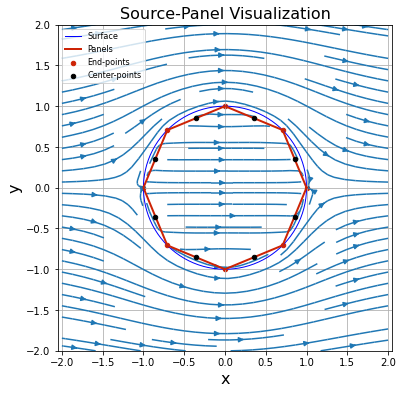

In [86]:
N_panels = 8

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_8 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)
panelPlot(x_cylinder, y_cylinder, cylinder_panels_8, x_ends_cylinder, y_ends_cylinder)

#Define mesh grid
nx, ny = 100, 100 
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0

panelStream(x_start, x_end, y_start, y_end, nx, ny, cylinder_panels_8, V_inf)

Below is the case for 32 and 128 panels

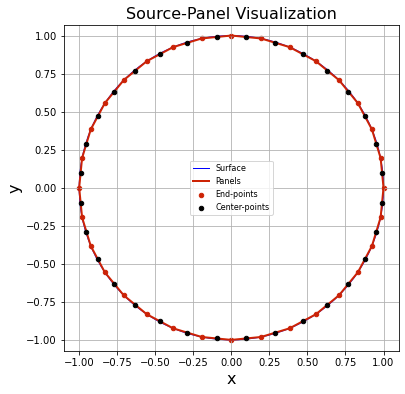

In [87]:
N_panels = 32

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_32 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)
panelPlot(x_cylinder, y_cylinder, cylinder_panels_32, x_ends_cylinder, y_ends_cylinder)

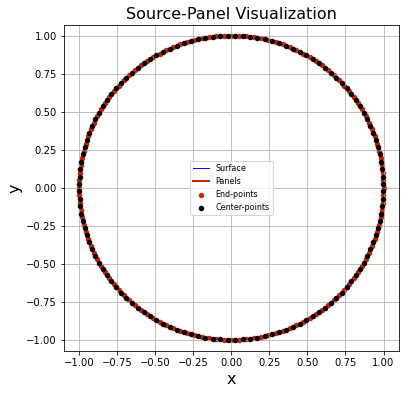

In [88]:
N_panels = 128

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_128 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)
panelPlot(x_cylinder, y_cylinder, cylinder_panels_128, x_ends_cylinder, y_ends_cylinder)

As we can see, as the number of panels increases, the approximation starts to match the original cylinder surface. Since each panel is distributed evenly across $\theta$, each panel is evenly spaced and has approximately the same length. We can expect the data for 128 panels to have more resolution and accuracy than the case of just 8 panels. We will see in the following section how the calculations hold.

### 1c. Closed Bodies and Surface Pressure Distributions
Before we make any comparisons, we want to confirm if each panel's source and sink strenghts add up to a zero. This is important to close the surface since any imbalance of strengths could cause the inner flow to interact with the outer flow which will invalidate our approximations of the dividing streamline as a solid body. We can do this by simply taking the sum of each source strength, multiplied by the length of the respective panel and seeing if this sum is approximately zero.

The sums are taken below and are shown above the plot. We can see that the value is approximately zero (an extremely small number) which is fine and is most probably due to rounding errors or and errors from the integration.

Now, we can compare the pressure coefficients from the analytical solution to that of the panel method. The analytical solution was derived by finding the radial velocity of a cylinder in a freestream, defined by a uniform flow and a doublet. The equations used are shown below:

$$V_\theta = -2V_\infty\sin\theta, r = R$$
$$C_P = \frac{P - P_\infty}{\frac{1}{2}\rho_\infty V_\infty^2} = \frac{\frac{\rho_\infty}{2}(V_\infty^2 - V_\theta^2)}{\frac{1}{2}\rho_\infty V_\infty^2} = 1-4\sin^2\theta$$

Since each panel stores it's $C_P$ value internally, we can simply index each panel and read the assigned $C_P$ values. Since we are also plotting this against $\theta$, we can read the stores $\theta_n$ value which corresponds to the normal vector angle which is the same as the $\theta$ we are originally plotting against. Below is the plot and as we can see, the approximation very closely matches the analytical results.

We can also look at the error which will be based on the integral of the analytical pressure distribution compared to the integral of the panel method pressure distributions. As expected, the error decreases as the number of panels increases. This seems to be a result of the added resolution to the $C_P$ data.

Sum of Strengths: 4.440892098500626e-16 (8 Panels), 1.2212453270876722e-15 (32 Panels), -9.43689570931383e-16 (128 Panels)
Error Metric: [1.26939513] (8 Panels), [0.39757778] (32 Panels), [0.09882861] (128 Panels)


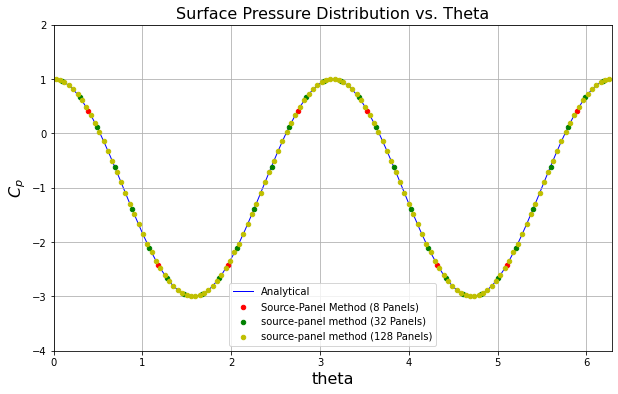

In [89]:
strengthSum_8 = sum([p.length*p.strength for p in cylinder_panels_8])
strengthSum_32 = sum([p.length*p.strength for p in cylinder_panels_32])
strengthSum_128 = sum([p.length*p.strength for p in cylinder_panels_128])

print("Sum of Strengths: {} (8 Panels), {} (32 Panels), {} (128 Panels)".format(strengthSum_8, strengthSum_32, strengthSum_128))

#Calculate the Analytical Cp
cp_analytical = 1.0 - 4 * (np.sin(theta))**2

#Plot the analytical and panel Cp
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('theta', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(theta, cp_analytical,
            label='Analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
plt.scatter([p.normAngle for p in cylinder_panels_8], [p.cp for p in cylinder_panels_8],
               label='Source-Panel Method (8 Panels)',
               color='r', s=20, zorder=2)
plt.scatter([p.normAngle for p in cylinder_panels_32], [p.cp for p in cylinder_panels_32],
               label='source-panel method (32 Panels)',
               color='g', s=20, zorder=2)
plt.scatter([p.normAngle for p in cylinder_panels_128], [p.cp for p in cylinder_panels_128],
               label='source-panel method (128 Panels)',
               color='y', s=20, zorder=2)
plt.title('Surface Pressure Distribution vs. Theta', fontsize=16)
plt.legend(loc='best')
plt.xlim(0, 2*math.pi)
plt.ylim(-4.0, 2.0);

#Calculate the error
CpAnalytical = np.trapz(cp_analytical, theta)
Cp_8 = np.trapz([p.cp for p in cylinder_panels_8], [np.linspace(0.0, 2 * math.pi, 8)])
Cp_32 = np.trapz([p.cp for p in cylinder_panels_32], [np.linspace(0.0, 2 * math.pi, 32)])
Cp_128 = np.trapz([p.cp for p in cylinder_panels_128], [np.linspace(0.0, 2 * math.pi, 128)])

CpError_8 = CpAnalytical - Cp_8
CpError_32 = CpAnalytical - Cp_32
CpError_128 = CpAnalytical - Cp_128
print("Error Metric: {} (8 Panels), {} (32 Panels), {} (128 Panels)".format(CpError_8, CpError_32, CpError_128))

### 1d. Sensitivity of the Solution
As we can see from the plot above, the points seem to closely match the analytical solutions when taking the pressure distribution with repsect to $\theta$. When we plot the same values with respect to $x$, we get some visible errors as shown below. This is most likely due to the panel locations, specifically in the case of 8 panels, where the panel locations are not tangent to the cylindrical surface. As the number of panels increase, the panels become approximately tangent to the surface such that the error or offset decreases as well.

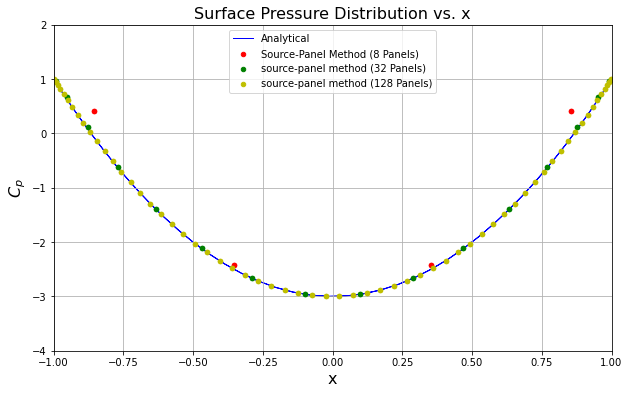

In [99]:
#Plot the analytical and panel Cp
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x_cylinder, cp_analytical,
            label='Analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
plt.scatter([p.xc for p in cylinder_panels_8], [p.cp for p in cylinder_panels_8],
               label='Source-Panel Method (8 Panels)',
               color='r', s=20, zorder=2)
plt.scatter([p.xc for p in cylinder_panels_32], [p.cp for p in cylinder_panels_32],
               label='source-panel method (32 Panels)',
               color='g', s=20, zorder=2)
plt.scatter([p.xc for p in cylinder_panels_128], [p.cp for p in cylinder_panels_128],
               label='source-panel method (128 Panels)',
               color='y', s=20, zorder=2)
plt.title('Surface Pressure Distribution vs. x', fontsize=16)
plt.legend(loc='best')
plt.xlim(-1, 1)
plt.ylim(-4.0, 2.0);

### 1e. Error Plots
We can plot the error as a function of the number of panels. To make the plot more populated, we can calculate the error for 16, 64, and 256 panels as well. In order to see the slope better, the plot was made in a log-log scale. The plot is shown below.

As we can see, the error is approximately linear (in a log-log scale). This will appear as an error that is initially (relatively) large that sharply decreases. After an increasing number of panels, the decrease in error also decreases such that we have diminishing accuracy returns for a larger number of panels.

Text(0, 0.5, 'Error')

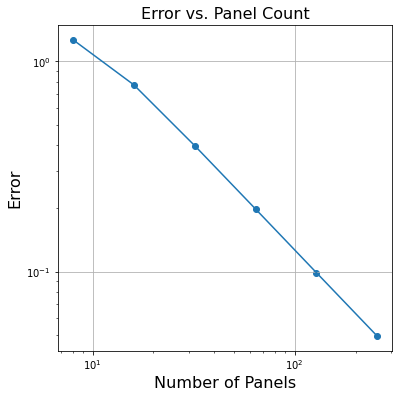

In [91]:
N_panels = 16

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_16 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)
#---

N_panels = 64

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_64 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)

#---
N_panels = 256

x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

cylinder_panels_256 = panelMethod(V_inf, x_ends_cylinder, y_ends_cylinder)

#---
Cp_16 = np.trapz([p.cp for p in cylinder_panels_16], [np.linspace(0.0, 2 * math.pi, 16)])
Cp_64 = np.trapz([p.cp for p in cylinder_panels_64], [np.linspace(0.0, 2 * math.pi, 64)])
Cp_256 = np.trapz([p.cp for p in cylinder_panels_256], [np.linspace(0.0, 2 * math.pi, 256)])

CpError_16 = CpAnalytical - Cp_16
CpError_64 = CpAnalytical - Cp_64
CpError_256 = CpAnalytical - Cp_256

plt.figure(figsize=(6, 6))
plt.loglog([8, 16, 32, 64, 128, 256], [CpError_8, CpError_16, CpError_32, CpError_64, CpError_128, CpError_256])
plt.scatter([8, 16, 32, 64, 128, 256], [CpError_8, CpError_16, CpError_32, CpError_64, CpError_128, CpError_256])
plt.grid()
plt.title("Error vs. Panel Count", fontsize = 16)
plt.xlabel('Number of Panels', fontsize=16)
plt.ylabel('Error', fontsize=16)

Finally, we can use the velocity component function to plot the streamlines for a given panel and freestream condition (Note: Panels are defined using a specific freestream so these freestreams need to be the same). We will be looking at the stream plot of the 32 panel cylinder in a horizontal freestream of 1 $\frac{\text{m}}{\text{s}}$. The plot is shown below:

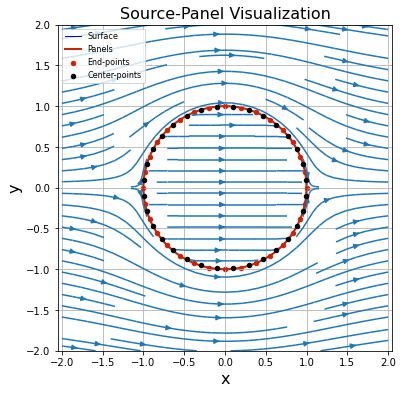

In [92]:
x_ends_cylinder = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends_cylinder = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

panelPlot(x_cylinder, y_cylinder, cylinder_panels_32, x_ends_cylinder, y_ends_cylinder)

#Define mesh grid
nx, ny = 100, 100 
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0

panelStream(x_start, x_end, y_start, y_end, nx, ny, cylinder_panels_32, V_inf)

## Problem 2: Symmetric Airfoil
### 2a. Airflow over a NACA 0020 Airfoil
Now that we know our panel method solver is working as it should, we can apply the same solver to a symmetric NACA airfoil. In this project, we will be using the NACA 0020 airfoil and the function used to define the NACA points is taken from the previous projects and slighlty modified to use a variable number of $x$-points to define the airfoil geometry.

After generating the points, we only need to index the points such that we are following the same counter-clockwise convention for indexing the endpoints and avoid any duplicate points (aside from the first and last points). Then, we only need to feed these functions to our panel method solver to generate the panels which will give us the $C_P$ distribution across each panel, which can be used to find lift.

The panel method solver doesn't need any pther changes, but a new panel plotting function was made to not plot the center points due to the sheer amount of panels used and plot very small endpoints. This lets us visualize the panels but not have the plot become too cluttered

In [93]:
def SymmetricNACA(c, tau, points):
    #Calculate t as a percentage
    t = tau/100
    #Make a vector x from 0 to 1 with a determined number of points
    x_norm = np.linspace(0, 1, points)
    #Calculates z_t/c (thickness on either side of the camper line which is flat for symmetric airfoils)
    z_t_norm = (t/0.2)*(0.2969*((x_norm)**(1/2)) - 0.1260*(x_norm) - 0.3516*((x_norm)**2) + 0.2843*((x_norm)**3) - 0.1015*((x_norm)**4))
    #Returns x and z_t as a tuple after redimensionalizing with c
    return x_norm*c, z_t_norm*c

def panelPlot(surf_x, surf_y, panels, x_ends, y_ends):
    size = 6
    plt.figure(figsize=(size, size))
    plt.grid()
    plt.title("Source-Panel Visualization", fontsize = 16)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.plot(surf_x, surf_y,
                label='Surface',
                color='b', linestyle='-', linewidth=1)
    plt.scatter([p.xa for p in panels], [p.ya for p in panels],
                label='End-points',
                color='#CD2305', s=10)
    plt.plot(x_ends, y_ends,
                label='Panels',
                color='#CD2305', linestyle='-', linewidth=2)
    plt.legend(loc='best', prop={'size':8})
    plt.axis('equal')

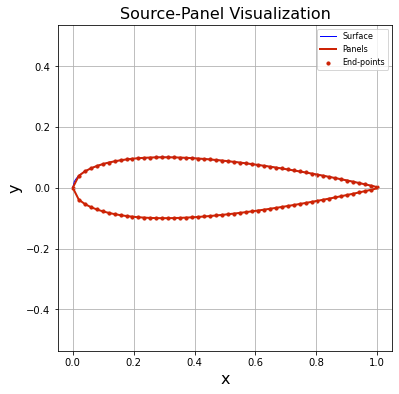

In [94]:
#Define the surface with 201 points (on each surface)
NACA0020_x, NACA0020_y = SymmetricNACA(1, 20, 201)
#Define the endpoints with 52 points on each surface (51 panels on each surface, 102 total)
NACA0020_x_panels, NACA0020_y_panels = SymmetricNACA(1, 20, 52)

NACA0020_x_ends = np.concatenate((NACA0020_x_panels[::-1], NACA0020_x_panels[1:]))
NACA0020_y_ends = np.concatenate((NACA0020_y_panels[::-1], -NACA0020_y_panels[1:]))

NACApanels_102 = panelMethod(V_inf, NACA0020_x_ends, NACA0020_y_ends)
panelPlot(NACA0020_x, NACA0020_y, NACApanels_102, NACA0020_x_ends, NACA0020_y_ends)


### 2b. Surface Pressure Distribution: Our Method vs. XFOIL
In the previous projects, we used XFOIL which is another panel method solver that is widely used. We can compare our surface pressure distributions to the results given by XFOIL for inviscid airflow (since we do not simulate viscous effects). Plotted below is the plot of surface pressure distribution over each panel as a function of $x$. As expected, we have a symmetric airfoil so the pressure distribution on both the upper and lower surfaces should be equivalent (such that the lift is zero for a zero angle of attack).

We also plotted the results of XFOIL so we can see how close our results are to their program.

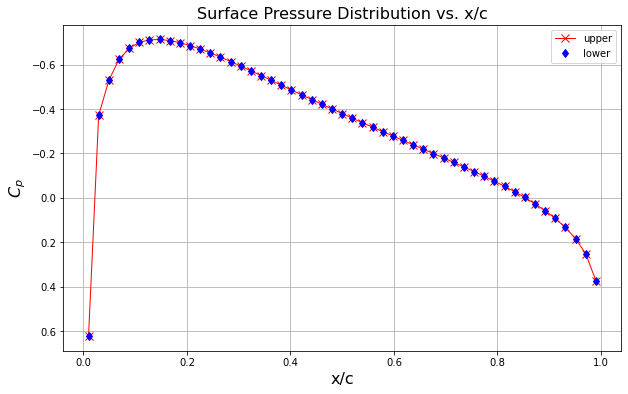

In [95]:
#Read XFoil Data
#[x, Cp] = np.loadtxt('/Users/jmtiu/Documents/Python/EAE 127/Project 0/Data/naca66210_geom.txt', unpack = True, skiprows = 1)

#Plot the analytical and panel Cp
plt.figure(figsize=(10, 6))
plt.grid()
#plt.plot(theta, cp_analytical,
#            label='Analytical',
#            color='b', linestyle='-', linewidth=1, zorder=1)
plt.plot([panel.xc for panel in NACApanels_102 if panel.loc == 'upper'],
            [panel.cp for panel in NACApanels_102 if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
plt.plot([panel.xc for panel in NACApanels_102 if panel.loc == 'lower'],
            [panel.cp for panel in NACApanels_102 if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
plt.xlabel('x/c', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.title('Surface Pressure Distribution vs. x/c', fontsize=16)
plt.gca().invert_yaxis()
plt.legend(loc='best')

### 2c. Streamlines Around an Airfoil
We can also plot the streamlines surrounding our airfoil using the previously discussed functions. This lets us visualize flow around the airfoil. Looking at the results below which very closely matches the airfoil, this is much better than the singularity trial-and-error method we used in the last project and required less time (not counting the setup required). This is one reason why the panel method is useful, since any input geometry of points (with some slight modifications for different geometries) can be approximated as sheets of singularities rather than the trial-and-error method used previously.

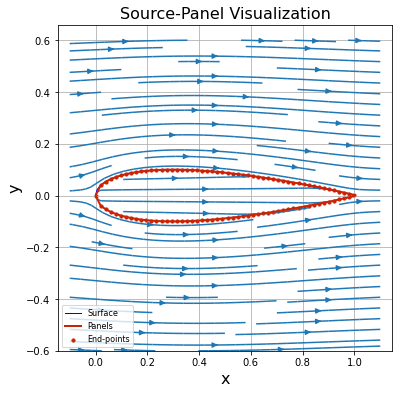

In [96]:
panelPlot(NACA0020_x, NACA0020_y, NACApanels_102, NACA0020_x_ends, NACA0020_y_ends)

#Define mesh grid
nx, ny = 100, 100 
x_start, x_end = -0.1, 1.1
y_start, y_end = -0.6, 0.6

panelStream(x_start, x_end, y_start, y_end, nx, ny, NACApanels_102, V_inf)

### 2d. Lift and Drag Coefficients
Now, the main reason why we would want to do all this is to find the $C_P$ at points on an airfoil. The pressure distribution would allow us to find the lift and drag coefficients. Luckily, this is something that we have done in previous projects so we can simply copy and adapt the code to a function that calculates $C_l$ and $C_d$ given a set of upper and lower pressure distributions.

In [97]:
def CalculateClCd(UpperCp, LowerCp, x, upper_y, lower_y, alpha):
    dzdx_Upper = np.gradient(upper_y, x)
    dzdx_Lower = np.gradient(lower_y, x)    

    C_n = -np.trapz((LowerCp - UpperCp), x)
    C_a = -np.trapz((UpperCp*dzdx_Upper - LowerCp*dzdx_Lower), x)
    C_mLE = -np.trapz((UpperCp - LowerCp)*x, x)

    C_l = C_n*np.cos(np.radians(alpha)) - C_a*np.sin(np.radians(alpha))
    C_d = C_n*np.sin(np.radians(alpha)) + C_a*np.cos(np.radians(alpha))
    C_m = C_mLE + C_l*0.25

    return C_l, C_d, C_m

Now we can use this function to find the lift and drag coefficients for an increasing number of panels. We just have to make a for-loop that goes across each panel and integrates the $C_l$ and $C_d$ values accordingly. The plot for the coefficients for an increasing number of panels is shown below. 

As expected of a symmetric airfoil at a zero angle-of-attack, the $C_l$ and $C_m$ values are approximately zero. Based on the XFOIL results, we can expect a negative drag coefficient due to the suction peak near the leading edge (and no friction or viscous effects). Going back to the XFOIL results, we see that $C_d$ due to pressure is expected to be around $-0.00195$.

Looking at the plot, we are not too far from the expected value but based on a percent difference, we are still quite far. Interestingly, the case of 12 panels is actually the closest of all the derived $C_d$ values, where increasing the number of panels causes an initial sharp decrease and the $C_d$ starts rising up again.

Cl = -1.554312234475219e-16, Cd = -0.01027930286202304, Cd = 4.7739590058881737e-17 (12 Panels)
Cl = -5.0464682937507145e-17, Cd = -0.02994291018838167, Cd = 5.2070377394609626e-17 (24 Panels)
Cl = -4.8270566288050363e-17, Cd = -0.038805832679150574, Cd = 4.732614216502322e-17 (48 Panels)
Cl = -1.1338447911065433e-16, Cd = -0.037662005265955756, Cd = 5.1867368103809956e-17 (96 Panels)
Cl = 1.402386978473882e-17, Cd = -0.03100277243903418, Cd = 4.7447426105033004e-17 (192 Panels)
Cl = -8.777155849130816e-17, Cd = -0.02316944558648655, Cd = 3.062844240997707e-17 (384 Panels)


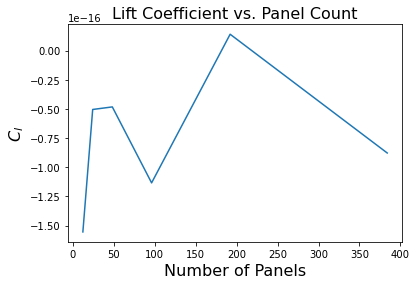

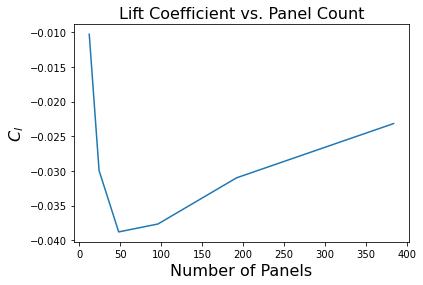

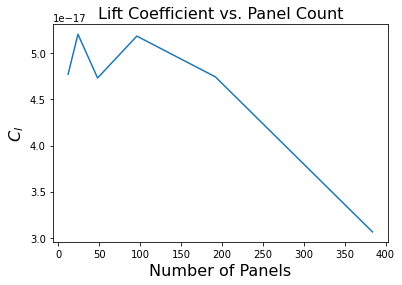

In [98]:
alpha = math.atan(V_inf[1]/V_inf[0])

panelCounts = [12, 24, 48, 96, 192, 384]

C_l_out = np.empty(len(panelCounts))
C_d_out = np.empty(len(panelCounts))
C_m_out = np.empty(len(panelCounts))

for i, panelCount in enumerate(panelCounts):
    NACA0020_x_panels, NACA0020_y_panels = SymmetricNACA(1, 20, int(panelCount/2))

    NACA0020_x_ends = np.concatenate((NACA0020_x_panels[::-1], NACA0020_x_panels[1:]))
    NACA0020_y_ends = np.concatenate((NACA0020_y_panels[::-1], -NACA0020_y_panels[1:]))

    NACApanels = panelMethod(V_inf, NACA0020_x_ends, NACA0020_y_ends)
    
    UpperCp = np.asarray([panel.cp for panel in NACApanels if panel.loc == 'upper'])
    LowerCp = np.asarray([panel.cp for panel in NACApanels[::-1] if panel.loc == 'lower'])
    panel_xc = np.asarray([panel.xc for panel in NACApanels if panel.loc == 'upper'])
    Upper_y = np.asarray([panel.yc for panel in NACApanels if panel.loc == 'upper'])
    Lower_y = np.asarray([panel.yc for panel in NACApanels[::-1] if panel.loc == 'lower'])

    C_l, C_d, C_m = CalculateClCd(UpperCp, LowerCp, panel_xc, Upper_y, Lower_y, alpha)
    print("Cl = {}, Cd = {}, Cd = {} ({} Panels)".format(C_l, C_d, C_m, panelCount))

    C_l_out[i] = C_l
    C_d_out[i] = C_d
    C_m_out[i] = C_m

plt.xlabel('Number of Panels', fontsize=16)
plt.ylabel('$C_l$', fontsize=16)
plt.title('Lift Coefficient vs. Panel Count', fontsize=16)
plt.plot(panelCounts, C_l_out)
plt.show()

plt.xlabel('Number of Panels', fontsize=16)
plt.ylabel('$C_l$', fontsize=16)
plt.title('Lift Coefficient vs. Panel Count', fontsize=16)
plt.plot(panelCounts, C_d_out)
plt.show()

plt.xlabel('Number of Panels', fontsize=16)
plt.ylabel('$C_l$', fontsize=16)
plt.title('Lift Coefficient vs. Panel Count', fontsize=16)
plt.plot(panelCounts, C_m_out)
plt.show()

## Problem 3: Additional Problems

### 3.1. Irrotationality
As we saw in lecture, irrotationality is defined when the curl of the velocity field is zero (zero vorticity). We can find the velocity field by taking $x$ and $y$ partial derivatives of the velocity field. We can derive a velocity field from the velocity potential function, $\phi$. The velocity potential function of a point source at the origin is shown below:

$$\phi = \frac{\Lambda}{2\pi}\ln r = \frac{\Lambda}{2\pi}\ln \sqrt{x^2 + y^2}$$

For two-dimensional flows, we are only concerned with the flow in the $x$ and $y$ directions which can be found using partial derivatives in these directions. These partial derivatives are shown below:

$$u = \frac{\partial\phi}{\partial x} = \frac{\Lambda}{2\pi} \frac{\frac{x}{\sqrt{x^2 + y^2}}}{\sqrt{x^2 + y^2}} = \frac{\Lambda}{2\pi} \frac{x}{x^2 + y^2}$$
$$v = \frac{\partial\phi}{\partial y} = \frac{\Lambda}{2\pi} \frac{\frac{y}{\sqrt{x^2 + y^2}}}{\sqrt{x^2 + y^2}} = \frac{\Lambda}{2\pi} \frac{y}{x^2 + y^2}$$
$$\vec{V}(x, y) = \langle u(x, y), v(x, y) \rangle = \langle \frac{\Lambda}{2\pi} \frac{x}{x^2 + y^2}, \frac{\Lambda}{2\pi} \frac{y}{x^2 + y^2} \rangle$$

Now, we can take the curl of the velocity field:

$$\frac{\partial u}{\partial y} = \frac{\Lambda}{2\pi} \frac{-2xy}{(x^2 + y^2)^2}$$
$$\frac{\partial v}{\partial x} = \frac{\Lambda}{2\pi} \frac{-2xy}{(x^2 + y^2)^2}$$
$$\vec{\nabla} \times \vec{V} = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} = \frac{\Lambda}{2\pi} \frac{-2xy}{(x^2 + y^2)^2} - \frac{\Lambda}{2\pi} \frac{-2xy}{(x^2 + y^2)^2} = 0$$

Since the curl is zero for all points $x$ and $y$, we can then say that the flow is irrotational.


### 3.2.Circular Cylinder
We are given a strut that is approximated as a circular cylinder and we want to know the pressure at the leading edge and 45 degrees from the leading edge. We were given a diameter of 12 inches at 20,000 feet standard atmosphere and 175 knots of airspeed. We can use the analytical model of $C_P$ around a cylindrical surface to find pressure:

$$C_P = 1-4\sin^2\theta = \frac{P-P_\infty}{\frac{1}{2}\rho_\infty V_\infty^2}$$

This allows us to solve for pressure as a function of $\theta$, $\rho_\infty$, $V_\infty$ and $P_\infty$:

$$P = (1-4\sin^2\theta)\frac{1}{2}\rho_\infty V_\infty^2 + P_\infty$$

Plugging in $\theta = 0, 45$ (deg), $\rho_\infty = 0.0012664 \frac{\text{slugs}}{\text{ft}^3}$, $V_\infty = 175 \text{ kts}$ and $P_\infty = 972 \text{ psf}$ gives us $P_{LE}$ = 1027.25 psf $P_{45 \text{ deg}}$ = 916.74 psf.


In [102]:
theta = [0, 45*math.pi/180]
rho = 0.0012664
V = 175*1.688
P = 972

P = (1 - 4*((np.sin(theta))**2))*0.5*rho*(V**2) + P
print("Pressure = {} psf (LE), {} psf (45 degrees)".format(P[0], P[1]))

Pressure = 1027.253766512 psf (LE), 916.746233488 psf (45 degrees)
